In [2]:
#Packages
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [4]:
#Get Data
csv_dir = '../..//SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [5]:
#Get all sliders
bbs = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider'])]
print(bbs.shape)

(61229, 167)


In [6]:
#Subset sliders into platoon splits
bbs_rr = bbs[(bbs['PitcherThrows'] == 'Right') & (bbs['BatterSide'] == 'Right')]
bbs_rl = bbs[(bbs['PitcherThrows'] == 'Right') & (bbs['BatterSide'] == 'Left')]
bbs_lr = bbs[(bbs['PitcherThrows'] == 'Left') & (bbs['BatterSide'] == 'Right')]
bbs_ll = bbs[(bbs['PitcherThrows'] == 'Left') & (bbs['BatterSide'] == 'Left')]

print(bbs_rr.shape)
print(bbs_rl.shape)
print(bbs_lr.shape)
print(bbs_ll.shape)

(31007, 167)
(11871, 167)
(9079, 167)
(9199, 167)


In [7]:
#Whiffs
bbs_rr['whiff'] = np.where(bbs_rr['PitchCall']=='StrikeSwinging',1,0)
bbs_rl['whiff'] = np.where(bbs_rl['PitchCall']=='StrikeSwinging',1,0)
bbs_lr['whiff'] = np.where(bbs_lr['PitchCall']=='StrikeSwinging',1,0)
bbs_ll['whiff'] = np.where(bbs_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_30724\2419019808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbs_rr['whiff'] = np.where(bbs_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_30724\2419019808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbs_rl['whiff'] = np.where(bbs_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_30724\2419019808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [8]:
#Predictor Variables
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

Righty vs. Righty Split

In [9]:
bbs_rr_X = bbs_rr[preds]
bbs_rr_y = bbs_rr['whiff']

In [10]:
#Train Model: RHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bbs_rr_X, bbs_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.28%


ROC AUC: 0.5202


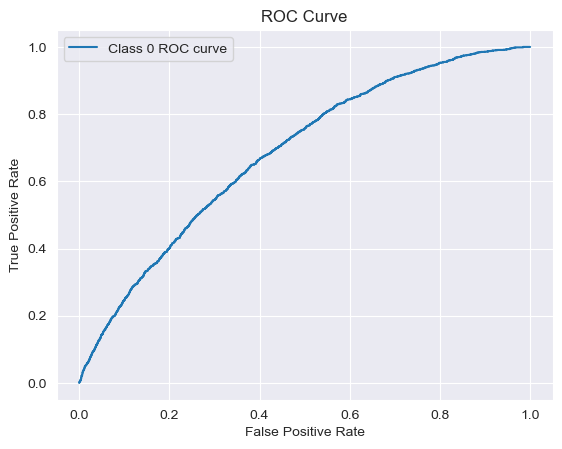

In [11]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [13]:
aub_bbs_rr = bbs_rr[bbs_rr['PitcherTeam']=='AUB_TIG']
print(aub_bbs_rr.shape)

(1786, 168)


In [14]:
# Get unique values
unique_values = bbs_rr['Pitcher'].unique()
aub_unique_values = aub_bbs_rr['Pitcher'].unique()

#Print list of Auburn pitchers for selected split
print(aub_unique_values)


# Create a dictionary to store subsets
subsets = {value: bbs_rr[bbs_rr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: bbs_rr[bbs_rr['Pitcher'] == value] for value in aub_unique_values}

['Allsup, Chase' 'Armstrong, John' 'Gonzalez, Joseph' 'Isbell, Chase'
 'Herberholz, Christian' 'Carlson, Parker' 'Horne, Trevor' 'Cannon, Will'
 'Keshock, Cameron' 'Murphy, Hayden' 'Tilly, Cameron' 'McBride, Connor'
 'Watts, Dylan' 'Petrovic, Alexander' 'Schorr, Ben']


In [25]:
def aub_rr_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} slider rr stuff+: {np.mean(stuff * 100)}")

    


In [26]:
#Stuff+ for selected Auburn pitchers Slider in RHP v RHB split
for pitcher in aub_unique_values:
    aub_rr_bbs_stuff(pitcher)

Allsup, Chase slider rr stuff+: 102.43026733398438
Armstrong, John slider rr stuff+: 94.26728057861328
Gonzalez, Joseph slider rr stuff+: 79.44835662841797
Isbell, Chase slider rr stuff+: 164.6420440673828
Herberholz, Christian slider rr stuff+: 84.32929229736328
Carlson, Parker slider rr stuff+: 75.06892395019531
Horne, Trevor slider rr stuff+: 63.88495635986328
Cannon, Will slider rr stuff+: 122.27600860595703
Keshock, Cameron slider rr stuff+: 34.08131408691406
Murphy, Hayden slider rr stuff+: 82.09925842285156
Tilly, Cameron slider rr stuff+: 92.21161651611328
McBride, Connor slider rr stuff+: 112.79237365722656
Watts, Dylan slider rr stuff+: 77.86878967285156
Petrovic, Alexander slider rr stuff+: 52.149986267089844
Schorr, Ben slider rr stuff+: 199.0371551513672


Righty vs. Lefty Split

In [29]:
bbs_rl_X = bbs_rl[preds]
bbs_rl_y = bbs_rl['whiff']

In [30]:
#Train Model: RHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bbs_rl_X, bbs_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.96%


In [31]:
aub_bbs_rl = bbs_rl[bbs_rl['PitcherTeam']=='AUB_TIG']
print(aub_bbs_rl.shape)

(709, 168)


In [32]:
# Get unique values
unique_values = bbs_rl['Pitcher'].unique()
aub_unique_values = aub_bbs_rl['Pitcher'].unique()

#Print list of Auburn pitchers for selected split
print(aub_unique_values)

# Create a dictionary to store subsets
subsets = {value: bbs_rl[bbs_rl['Pitcher'] == value] for value in unique_values}
aub_subsets = {value: bbs_rl[bbs_rl['Pitcher'] == value] for value in aub_unique_values}

['Allsup, Chase' 'Armstrong, John' 'Cannon, Will' 'Gonzalez, Joseph'
 'Isbell, Chase' 'Carlson, Parker' 'Herberholz, Christian' 'Horne, Trevor'
 'Murphy, Hayden' 'McBride, Connor' 'Watts, Dylan' 'Keshock, Cameron'
 'Tilly, Cameron' 'Petrovic, Alexander' 'Schorr, Ben']


In [33]:
def aub_rl_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} slider rl stuff+: {np.mean(stuff * 100)}")


In [34]:
#Stuff+ for selected Auburn pitchers Slider in RHP v LHB split
for pitcher in aub_unique_values:
    aub_rl_bbs_stuff(pitcher)

Allsup, Chase slider rl stuff+: 139.5819091796875
Armstrong, John slider rl stuff+: 94.0444564819336
Cannon, Will slider rl stuff+: 92.2946548461914
Gonzalez, Joseph slider rl stuff+: 71.0603256225586
Isbell, Chase slider rl stuff+: 133.53912353515625
Carlson, Parker slider rl stuff+: 117.83186340332031
Herberholz, Christian slider rl stuff+: 103.3445053100586
Horne, Trevor slider rl stuff+: 119.78644561767578
Murphy, Hayden slider rl stuff+: 4.621572017669678
McBride, Connor slider rl stuff+: 78.33538055419922
Watts, Dylan slider rl stuff+: 110.16651153564453
Keshock, Cameron slider rl stuff+: 79.19733428955078
Tilly, Cameron slider rl stuff+: 107.9838638305664
Petrovic, Alexander slider rl stuff+: 68.45745086669922
Schorr, Ben slider rl stuff+: 90.3016357421875


Lefty vs. Righty Split

In [35]:
bbs_lr_X = bbs_lr[preds]
bbs_lr_y = bbs_lr['whiff']

In [36]:
#Train Model: LHP vs RHB
X_train, X_test, y_train, y_test = train_test_split(bbs_lr_X, bbs_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.85%


In [37]:
aub_bbs_lr = bbs_lr[bbs_lr['PitcherTeam']=='AUB_TIG']
print(aub_bbs_lr.shape)

(590, 168)


In [39]:
# Get unique values
unique_values = bbs_lr['Pitcher'].unique()
aub_unique_values = aub_bbs_lr['Pitcher'].unique()


#Print list of Auburn pitchers for selected split
print(aub_unique_values)

# Create a dictionary to store subsets
subsets = {value: bbs_lr[bbs_lr['Pitcher'] == value] for value in unique_values}
aub_subsets = {value: bbs_lr[bbs_lr['Pitcher'] == value] for value in aub_unique_values}


['Bauman, Tanner' 'Vail, Tommy' 'Crotchfelt, Zach' 'Copeland, Konner'
 'Nelson, Drew' 'Sheehan, Tommy' 'Myers, Carson' 'Graves, Griffin'
 'Keplinger, Konner']


In [40]:
def aub_lr_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} slider lr stuff+: {np.mean(stuff * 100)}")


In [41]:
#Stuff+ for selected Auburn pitchers Slider in LHP v RHB split
for pitcher in aub_unique_values:
    aub_lr_bbs_stuff(pitcher)

Bauman, Tanner slider lr stuff+: 102.19255828857422
Vail, Tommy slider lr stuff+: 66.79165649414062
Crotchfelt, Zach slider lr stuff+: 62.21558380126953
Copeland, Konner slider lr stuff+: 48.29532241821289
Nelson, Drew slider lr stuff+: 11.15235424041748
Sheehan, Tommy slider lr stuff+: 272.33587646484375
Myers, Carson slider lr stuff+: 67.07564544677734
Graves, Griffin slider lr stuff+: 102.34194946289062
Keplinger, Konner slider lr stuff+: 7.867163181304932


Lefty vs. Lefty Split

In [42]:
bbs_ll_X = bbs_ll[preds]
bbs_ll_y = bbs_ll['whiff']

In [43]:
#Train Model: LHP vs LHB
X_train, X_test, y_train, y_test = train_test_split(bbs_ll_X, bbs_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.17%


In [44]:
aub_bbs_ll = bbs_ll[bbs_ll['PitcherTeam']=='AUB_TIG']
print(aub_bbs_ll.shape)

(592, 168)


In [45]:
# Get unique values
unique_values = bbs_ll['Pitcher'].unique()
aub_unique_values = aub_bbs_ll['Pitcher'].unique()

#Print list of Auburn pitchers for selected split
print(aub_unique_values)

# Create a dictionary to store subsets
subsets = {value: bbs_ll[bbs_ll['Pitcher'] == value] for value in unique_values}
aub_subsets = {value: bbs_ll[bbs_ll['Pitcher'] == value] for value in aub_unique_values}



['Bauman, Tanner' 'Sheehan, Tommy' 'Vail, Tommy' 'Crotchfelt, Zach'
 'Copeland, Konner' 'Nelson, Drew' 'Myers, Carson' 'Graves, Griffin'
 'Keplinger, Konner']


In [46]:
def aub_ll_bbs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(bbs_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} slider ll stuff+: {np.mean(stuff * 100)}")


In [47]:
#Stuff+ for selected Auburn pitchers Slider in LHP v LHB split
for pitcher in aub_unique_values:
    aub_ll_bbs_stuff(pitcher)

Bauman, Tanner slider ll stuff+: 81.21873474121094
Sheehan, Tommy slider ll stuff+: 98.68891143798828
Vail, Tommy slider ll stuff+: 56.72083282470703
Crotchfelt, Zach slider ll stuff+: 57.95381164550781
Copeland, Konner slider ll stuff+: 94.70841979980469
Nelson, Drew slider ll stuff+: 38.75656509399414
Myers, Carson slider ll stuff+: 76.60381317138672
Graves, Griffin slider ll stuff+: 71.02580261230469
Keplinger, Konner slider ll stuff+: 58.785728454589844
